In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(sys.path[0] + '/../'))
torch.cuda.set_device(2)
print("Set CUDA:%d as current device." % torch.cuda.current_device())
torch.autograd.set_grad_enabled(False)

from data.spherical_view_syn import *
from configs.spherical_view_syn import SphericalViewSynConfig
from utils import netio
from utils import misc
from utils import img
from utils import device
from utils import view
from components.gen_final import GenFinal


def load_net(path):
    config = SphericalViewSynConfig()
    config.from_id(path[:-4])
    config.SAMPLE_PARAMS['perturb_sample'] = False
    #config.print()
    net = config.create_net().to(device.default())
    netio.load(path, net)
    return net


def find_file(prefix):
    for path in os.listdir():
        if path.startswith(prefix):
            return path
    return None


def load_views(data_desc_file) -> view.Trans:
    with open(data_desc_file, 'r', encoding='utf-8') as file:
        data_desc = json.loads(file.read())
        view_centers = torch.tensor(
            data_desc['view_centers'], device=device.default()).view(-1, 3)
        view_rots = torch.tensor(
            data_desc['view_rots'], device=device.default()).view(-1, 3, 3)
        return view.Trans(view_centers, view_rots)

scenes = {
    'gas': '__0_user_study/us_gas_all_in_one',
    'mc': '__0_user_study/us_mc_all_in_one',
    'bedroom': 'bedroom_all_in_one',
    'gallery': 'gallery_all_in_one',
    'lobby': 'lobby_all_in_one'
}

fov_list = [20, 45, 110]
res_list = [(128, 128), (256, 256), (256, 230)]
res_full = (1600, 1440)

Set CUDA:2 as current device.


Change working directory to  /home/dengnc/deep_view_syn/data/__0_user_study/us_gas_all_in_one
Load net from fovea@nmsl-rgb_e10_fc128x4_d1-50_s32.pth ...
Load net from periph_rgb@msl-rgb_e10_fc96x4_d1.00-50.00_s16.pth ...
Dataset loaded.
views: [2]


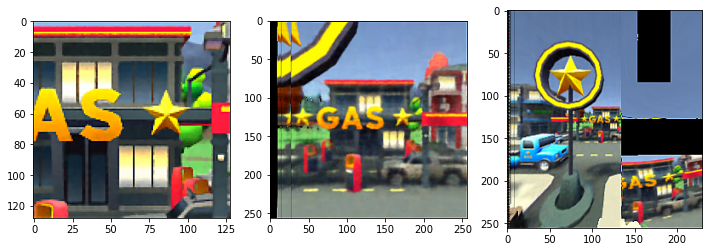

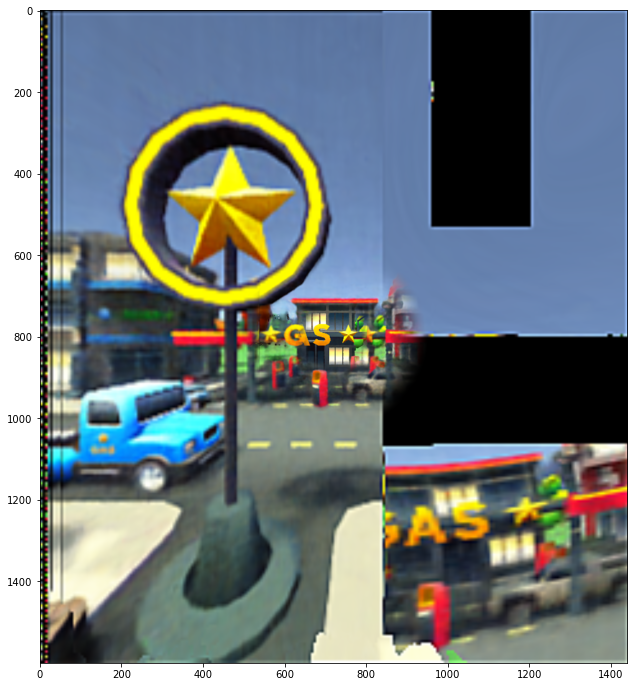

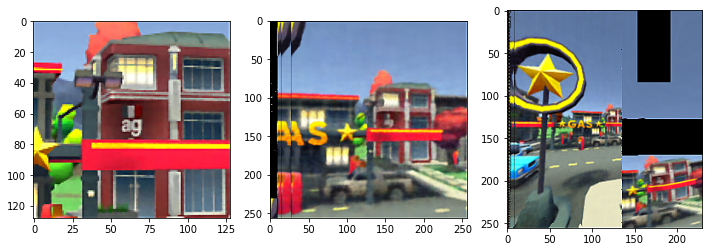

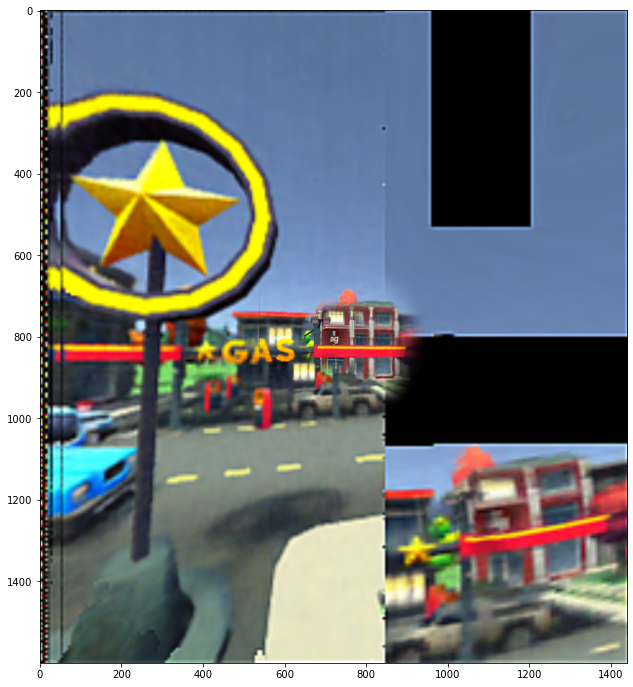

In [3]:
scene = 'gas'
os.chdir(sys.path[0] + '/../data/' + scenes[scene])
print('Change working directory to ', os.getcwd())

fovea_net = load_net(find_file('fovea'))
periph_net = load_net(find_file('periph'))

# Load Dataset
views = load_views('demo.json')
print('Dataset loaded.')
print('views:', views.size())
gen = GenFinal(fov_list, res_list, res_full, fovea_net, periph_net,
               device=device.default())

for view_idx in range(views.size()[0]):
    center = (0, 0)
    test_view = views.get(view_idx)
    images = gen(
        center, test_view,
        mono_trans=view.Trans(
            test_view.trans_point(torch.tensor([0.03, 0, 0], device=device.default())),
            test_view.r
        ),
        warp_by_depth=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    img.plot(images['fovea'])
    plt.subplot(132)
    img.plot(images['mid'])
    plt.subplot(133)
    img.plot(images['periph'])
    plt.figure(figsize=(12, 12))
    img.plot(images['blended'])
    '''
    images = gen(center, test_view)
    outputdir = '/home/dengnc/deep_view_syn/data/__2_demo/layer_blend/'
    misc.create_dir(outputdir)
    for key in images:
        img.save(images[key], outputdir +
                              '%s_view%04d_%s.png' % (scene, view_idx, key))
    '''
    '''
    images = gen(
        center, test_view,
        mono_trans=view.Trans(test_view.trans_point(
            torch.tensor([0.03, 0, 0], device=device.default())
        ), test_view.r))
    outputdir = '/home/dengnc/deep_view_syn/data/__2_demo/output_mono/ref_as_right_eye/'
    misc.create_dir(outputdir)
    for key in images:
    key = 'blended'
    img.save(images[key], outputdir +
                          '%s_view%04d_%s.png' % (scene, view_idx, key))
    '''
    '''
    left_images = gen(center,
                      view.Trans(
                          test_view.trans_point(
                              torch.tensor([-0.03, 0, 0], device=device.default())
                          ),
                          test_view.r),
                      mono_trans=test_view)
    right_images = gen(center, view.Trans(
        test_view.trans_point(
            torch.tensor([0.03, 0, 0], device=device.default())
        ), test_view.r), mono_trans=test_view)
    outputdir = '/home/dengnc/deep_view_syn/data/__2_demo/mono_periph/stereo/'
    misc.create_dir(outputdir)
    key = 'blended'
    img.save(left_images[key], outputdir +
                        '%s_view%04d_%s_l.png' % (scene, view_idx, key))
    img.save(right_images[key], outputdir +
                        '%s_view%04d_%s_r.png' % (scene, view_idx, key))
    '''

